In [ ]:
from datetime import datetime
import random 
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import make_scorer 
import matplotlib.pyplot as plt
import gensim.downloader as api
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from google.colab import drive
drive.mount('/content/gdrive')
dir_name = "/content/gdrive/MyDrive/Thesis/"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/gdrive


In [ ]:
def con2bin(label):
  if label in ['Psoriasis', 'Chicken pox', 'Impetigo', 'Acne']:
    return 1
  return 0

In [ ]:
def get_raw_data(dir_name):
    #  load data
    data = pd.read_csv('{}Symptom2Disease.csv'.format(dir_name), encoding = 'latin-1', usecols=['text', 'label'])
    data['label'] =  data['label'].apply(con2bin)
    return data

raw_data = get_raw_data(dir_name + 'datasets/')
raw_data

,label,text
0,1,I have been experiencing a skin rash on my arm...
1,1,"My skin has been peeling, especially on my kne..."
2,1,I have been experiencing joint pain in my fing...
3,1,"There is a silver like dusting on my skin, esp..."
4,1,"My nails have small dents or pits in them, and..."
...,...,...
1195,0,I'm shaking and trembling all over. I've lost ...
1196,0,"Particularly in the crevices of my skin, I hav..."
1197,0,I regularly experience these intense urges and...
1198,0,"I have trouble breathing, especially outside. ..."


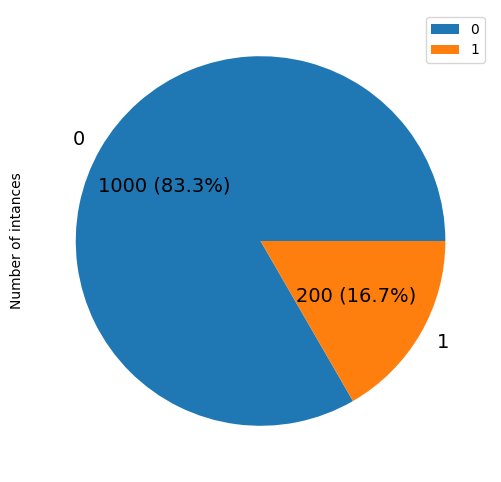

In [ ]:
def get_dataset_statistics(data):
    dataset_statistics = {'Number of intances': [data['label'].value_counts()[0], data['label'].value_counts()[1]]}
    df = pd.DataFrame(dataset_statistics, index=['0', '1'])
    df.plot(kind='pie', y='Number of intances', figsize=(6, 6), fontsize=14,
            autopct=lambda v: '{:.0f} ({:.1f}%)'.format(v / 100 * data['label'].count(), v))
    
get_dataset_statistics(raw_data)

In [ ]:
raw_data['text'].is_unique

False

In [ ]:
raw_data.drop_duplicates( inplace=True)
raw_data['text'].is_unique

True

In [ ]:
raw_data

,label,text
0,1,I have been experiencing a skin rash on my arm...
1,1,"My skin has been peeling, especially on my kne..."
2,1,I have been experiencing joint pain in my fing...
3,1,"There is a silver like dusting on my skin, esp..."
4,1,"My nails have small dents or pits in them, and..."
...,...,...
1195,0,I'm shaking and trembling all over. I've lost ...
1196,0,"Particularly in the crevices of my skin, I hav..."
1197,0,I regularly experience these intense urges and...
1198,0,"I have trouble breathing, especially outside. ..."


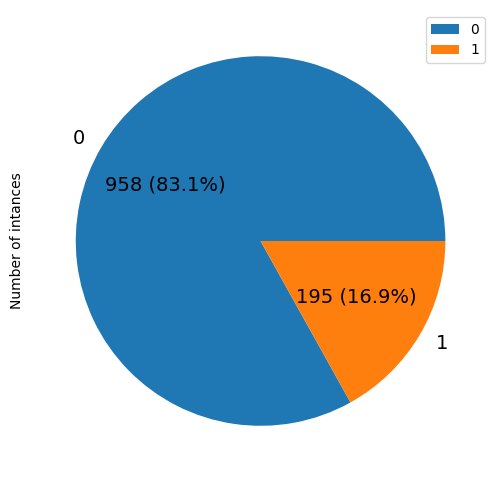

In [ ]:
get_dataset_statistics(raw_data)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(raw_data['text'].to_numpy(), raw_data['label'].to_numpy(), stratify=raw_data['label'].to_numpy(), test_size=0.2, random_state=24)

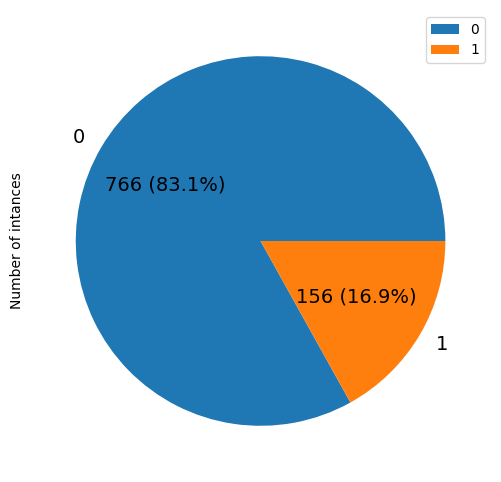

In [ ]:
get_dataset_statistics(pd.DataFrame({'label': y_train}))

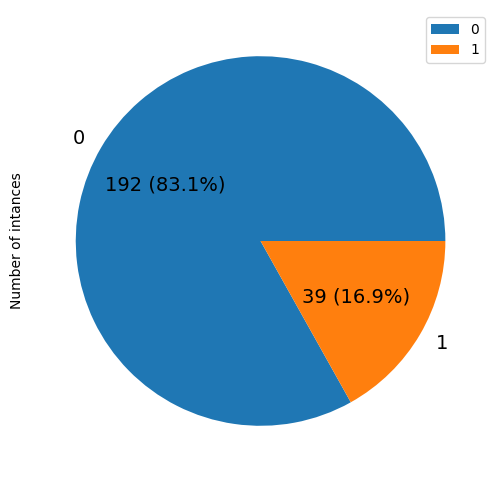

In [ ]:
get_dataset_statistics(pd.DataFrame({'label': y_test}))

In [ ]:
train_data = pd.DataFrame({'text': X_train, 'label': y_train})
train_data

,text,label
0,I am quite queasy and dizzy when I have a temp...,0
1,I've been experiencing muscular weakness and s...,0
2,"Over the last week, the rash on my face has go...",1
3,I have a frequent need to urinate and often ha...,0
4,I am feeling quite weak. I'm having a lot of s...,0
...,...,...
917,Sometimes my skin starts to flake off from my ...,0
918,My skin has a horrible rash that is absolutely...,1
919,I occasionally have burning in my upper abdome...,0
920,I lose weight unintentionally and find it chal...,0


In [ ]:
test_data = pd.DataFrame({'text': X_test, 'label': y_test})
test_data

,text,label
0,My cheeks and nose are covered with red sores....,1
1,"My vision is blurry, and it feels like it's ge...",0
2,I have noticed a sudden peeling of skin at dif...,1
3,I've been suffering from severe constipation l...,0
4,The sores around my nose are now surrounded by...,1
...,...,...
226,I have been feeling nauseous and have a consta...,0
227,I have a sour acidic taste in my mouth. I have...,0
228,I routinely experience heartburn and indigesti...,0
229,The veins on my calves have become very promin...,0


# Text Preprocessing 

In [ ]:
import requests
stopwords_list = requests.get("https://github.com/stopwords-iso/stopwords-en/blob/master/stopwords-en.txt").content
stopwords = set(stopwords_list.decode().splitlines())

In [ ]:
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
sklearn_stopwords = ENGLISH_STOP_WORDS

stop_words = set(stopwords.words('english'))
stop_words.update(sklearn_stopwords)

def text_preprocessing(raw_text):
  text_words = raw_text.translate(str.maketrans('', '', string.punctuation))
  msg_tokens = word_tokenize(text_words.lower())
  filtered_text = [token for token in msg_tokens if not token in stop_words]
  return " ".join(filtered_text)

In [ ]:
train_data = train_data[['text', 'label']].copy()

train_data['text'] = train_data['text'].apply(text_preprocessing)

train_data.drop_duplicates(inplace=True)

train_data

,text,label
0,quite queasy dizzy temperature brain completel...,0
1,ive experiencing muscular weakness stiffness n...,0
2,week rash face gotten severe painful sores beg...,1
3,frequent need urinate uncontrollable urges fee...,0
4,feeling quite weak im lot stomach discomfort c...,0
...,...,...
917,skin starts flake rashes im prone sick result ...,0
918,skin horrible rash absolutely nonheritable bla...,1
919,occasionally burning upper abdomen day night h...,0
920,lose weight unintentionally challenging acquir...,0


In [ ]:
test_data = test_data[['text', 'label']].copy()

test_data['text'] = test_data['text'].apply(text_preprocessing)

test_data.drop_duplicates(inplace=True)

test_data

,text,label
0,cheeks nose covered red sores ive observed ras...,1
1,vision blurry feels like getting worse time fe...,0
2,noticed sudden peeling skin different parts bo...,1
3,ive suffering severe constipation lately restr...,0
4,sores nose surrounded red inflamed skin rash c...,1
...,...,...
226,feeling nauseous constant urge vomit strong pa...,0
227,sour acidic taste mouth frequent belching burp...,0
228,routinely experience heartburn indigestion par...,0
229,veins calves prominent causing discomfort stan...,0


# Feature Extraction

In [ ]:
word2vec_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
def get_text_vec(sent):
  vector = np.mean(np.array([word2vec_model[token] for token in word_tokenize(sent) if token in word2vec_model.key_to_index]), axis=0)
  if np.all(np.isnan(vector)) :
    return np.zeros(300)
  return vector

In [ ]:
X_test = np.stack(np.array([get_text_vec(text) for text in test_data['text'].values]))

In [ ]:
X_test.shape

(231, 300)

In [ ]:
y_test = test_data['label'].values

In [ ]:
y_test.shape

(231,)

# Model selection, training and evaluation

In [ ]:
def f_beta_score(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

f2_score = make_scorer(f_beta_score, greater_is_better=True)

In [ ]:
from datetime import datetime

def save_cross_validation(results, file_name):
  results_to_save = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1 Score', 'F2 Score'])
  for i in range(0, 10):
    results_to_save.loc[i] = [
      results['split{}_test_Accuracy'.format(i)][0],
      results['split{}_test_Recall'.format(i)][0],
      results['split{}_test_Precision'.format(i)][0],
      results['split{}_test_F1'.format(i)][0],
      results['split{}_test_F2'.format(i)][0]
    ]
  results_to_save.to_csv('{}Results/{}_{}.csv'.format(dir_name+'experiments/Skin Diseases/', file_name, datetime.now().strftime("%m%d%H%M")))

In [ ]:
def train_model(classifier, param_grid, model_name, train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print=True, to_save=False, file_name=None):
    """
    train email classification model.
    """

    # apply grid search to find best model hyper parameters
    grid_search = GridSearchCV(classifier, param_grid, cv=10, scoring={'Accuracy': make_scorer(accuracy_score),
                                                                       'F1': make_scorer(f1_score),
                                                                       'F2': f2_score,
                                                                       'Recall': make_scorer(recall_score),
                                                                       'Precision': make_scorer(precision_score)
                                                                       }, refit='F1', n_jobs=-1)
    grid_search.fit(train_texts, train_labels)
    model = grid_search.best_estimator_

    if to_save:
      ConfusionMatrixDisplay(save_cross_validation(grid_search.cv_results_, file_name))
      plt.show()

    # train and test accuracy.
    test_accuracy = model.score(test_texts, test_labels)
    train_accuracy = model.score(train_texts, train_labels)

    # compute F1 score for model evaluation.
    y_pred = model.predict(test_texts)

    recall = recall_score(test_labels, y_pred)
    precision = precision_score(test_labels, y_pred)
    f1score = f1_score(test_labels, y_pred)
    f2score = fbeta_score(y_test, y_pred, beta=2)

    if to_print:
        print("train accuracy = " + str(train_accuracy))
        print("test accuracy = " + str(test_accuracy))
        print("Recall = {}".format(recall))
        print("Precision = {}".format(precision))
        print("F1 score = {}".format(f1score))
        print("F2 score = {}".format(f2score))
        print(classification_report(test_labels, y_pred))


        # plot confusion matrix
        cm = confusion_matrix(test_labels, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

        disp.plot(cmap=plt.cm.Blues)
        plt.show()

        # print best model hyper parameters.
        print(grid_search.best_params_)

    evaluation_metrics.loc[model_name, 'Recall'] = recall
    evaluation_metrics.loc[model_name, 'Precision'] = precision
    evaluation_metrics.loc[model_name, 'F1 score'] = f1score
    evaluation_metrics.loc[model_name, 'F2 score'] = f2score

    return f1score, f2score


def train(model_id, train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print=True, to_save=False, file_name=None):
    
    if model_id == 1:
        # Random forest Classification model.
        forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
        forest_param_grid = [{'n_estimators': [50, 75, 100, 150, 200], 'max_features': [8, 9, 10], 'min_samples_split': [25, 30], 'criterion': ['gini','entropy'], 'max_depth': [4, 5]}]
        return train_model(forest_clf, forest_param_grid, 'RandomForest', train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print, to_save, file_name)

    if model_id == 2:
        # Support Vector Machine Model.
        svc_clf = SVC(random_state=42)
        svc_param_grid = [{'kernel': ['rbf', 'poly'], 'degree': [2, 3 , 4, 5, 6, 7]}]

        return train_model(svc_clf, svc_param_grid, 'SVM', train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print, to_save, file_name)

#Text Aug.

In [ ]:
all_similar_words = {}

def get_similar_words(word):
  if word not in all_similar_words:
    all_similar_words[word] = word2vec_model.most_similar(word)
  return all_similar_words[word]

In [ ]:
import gensim
import random 

class Word2vec:
    """
    A set of functions used to augment data.
    Typical usage: :: 
        >>> from textaugment import Word2vec
        >>> t = Word2vec('path/to/gensim/model'or 'gensim model itself')
        >>> t.augment('I love school')
        i adore school
    """
    
    def __init__(self, **kwargs):
        """
        A method to initialize a model on a given path.
        :type random_state: int, float, str, bytes, bytearray
        :param random_state: seed
        :type model: str or gensim.models.word2vec.Word2Vec
        :param model: The path to the model or the model itself.
        :type runs: int, optional
        :param runs: The number of times to augment a sentence. By default is 1.
        :type v: bool or optional
        :param v: Replace all the words if true. If false randomly replace words.
                Used in a Paper (https://www.cs.cmu.edu/~diyiy/docs/emnlp_wang_2015.pdf)
        :type p: float, optional
        :param p: The probability of success of an individual trial. (0.1<p<1.0), default is 0.5
        """

        # Set random state
        if 'random_state' in kwargs:
            self.random_state = kwargs['random_state']
            if isinstance(self.random_state, int):
                random.seed(self.random_state)
                np.random.seed(self.random_state)
            else:
                raise TypeError("random_state must have type int")

        # Set verbose to false if does not exists
        try:
            if kwargs['v']: 
                self.v = True
            else:
                self.v = False
        except KeyError:
            self.v = False

        try:
            if "p" in kwargs:
                if type(kwargs['p']) is not float:
                    raise TypeError("p represent probability of success and must be a float from 0.1 to 0.9. E.g p=0.5")
                elif type(kwargs['p']) is float:
                    self.p = kwargs['p']
            else:
                kwargs['p'] = 0.5  # Set default value
        except KeyError:
            raise

        # Error handling of given parameters
        try:
            if "runs" not in kwargs:
                kwargs["runs"] = 1  # Default value for runs
            elif type(kwargs["runs"]) is not int:
                raise TypeError("DataType for 'runs' must be an integer")
            if "model" not in kwargs:
                raise ValueError("Set the value of model. e.g model='path/to/model' or model itself")
            if type(kwargs['model']) not in [str,
                                             gensim.models.word2vec.Word2Vec,
                                             gensim.models.keyedvectors.Word2VecKeyedVectors,
                                            gensim.models.keyedvectors.FastTextKeyedVectors]:
                raise TypeError("Model path must be a string. "
                                "Or type of model must be a gensim.models.word2vec.Word2Vec or "
                                "gensim.models.keyedvectors.Word2VecKeyedVectors or "
                                "gensim.models.keyedvectors.FastTextKeyedVectors type. "
                                "To load a model use gensim.models.Word2Vec.load('path')")
        except (ValueError, TypeError):
            raise
        else:
            self.runs = kwargs["runs"] 
            self.model = kwargs["model"]
            self.p = kwargs["p"]
            try:
                if type(self.model) is str:
                    self.model = gensim.models.Word2Vec.load(self.model)
            except FileNotFoundError:
                print("Error: Model not found. Verify the path.\n")
                raise

    def geometric(self, data):
        """
        Used to generate Geometric distribution.
        :type data: list
        :param data: Input data
        :rtype:   ndarray or scalar
        :return:  Drawn samples from the parameterized Geometric distribution.
        """

        data = np.array(data)
        first_trial = np.random.geometric(p=self.p, size=data.shape[0]) == 1  # Capture success after first trial
        return data[first_trial]

    def augment(self, data):
        """
        The method to replace words with similar words.
        
        :type data: str
        :param data: Input data
        :rtype:   str
        :return:  The augmented data
        """
        
        # Avoid nulls and other unsupported types
        if type(data) is not str: 
            raise TypeError("Only strings are supported")
        # Lower case and split
        data_tokens = data.lower().split()

        # Verbose = True then replace all the words.
        if self.v:
            for _ in range(self.runs):
                for index in range(len(data_tokens)):  # Index from 0 to length of data_tokens
                    try:
                        similar_words = [syn for syn, t in self.model.most_similar(data_tokens[index])]
                        r = random.randrange(len(similar_words))
                        data_tokens[index] = similar_words[r].lower()  # Replace with random synonym from 10 synonyms
                    except KeyError:
                        pass  # For words not in the word2vec model
        else:  # Randomly replace some words
            for _ in range(self.runs):
                data_tokens_idx = [[x, y] for (x, y) in enumerate(data_tokens)]  # Enumerate data
                words = self.geometric(data=data_tokens_idx).tolist()  # List of words indexed
                for w in words:
                    try:
                        similar_words_and_weights = [(syn, t) for syn, t in get_similar_words(w[1])]
                        similar_words = [word for word, t in similar_words_and_weights]
                        similar_words_weights = [t for word, t in similar_words_and_weights]
                        word = random.choices(similar_words, similar_words_weights, k=1)
                        data_tokens[int(w[0])] = word[0].lower()  # Replace with random synonym from 10 synonyms
                    except KeyError:
                        pass
            return " ".join(data_tokens)
        return " ".join(data_tokens)

In [ ]:
marivate_augmener = Word2vec(model=word2vec_model, runs=1, v=False, p=0.5)

In [ ]:
def marivate_augmentation(prepro_dataset, lable, sent_num=5):
  texts = prepro_dataset.loc[prepro_dataset['label'] == lable]['text'].values
  texts_num = len(texts)
  new_texts = []
  i = 0
  
  for text in texts:
    if i % 20 == 0:
      print(f" {int(100*i/texts_num)} %")
    for j in range(sent_num):
      new_texts.append(marivate_augmener.augment(text))
    i += 1
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_texts), 'text':new_texts}), ignore_index = True)
  augmentations.drop_duplicates(inplace=True)
  return augmentations.sample(frac=1)

In [ ]:
augmented_dataset = marivate_augmentation(train_data, lable=1, sent_num=3)

 0 %
 12 %
 25 %
 38 %
 51 %
 64 %
 77 %
 90 %


<ipython-input-20-27a6d5a3b793>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_texts), 'text':new_texts}), ignore_index = True)


In [ ]:
augmented_dataset

,text,label
1229,rash skin spread sections decomposing_body inc...,1
114,chronic cough limb weakness ive dealing excruc...,0
247,nails slightly dented joints experiencing excr...,1
390,im suffering severe itching chills vomiting hi...,0
632,ive suffering severe itching body driving insa...,1
...,...,...
587,lot itching skin gets really red bumpy patches...,0
152,skin acquired nasty rash pusfilled pimples bla...,1
773,ive lot trouble going bathroom lately really p...,0
459,morning realized major rash body lots pimples ...,1


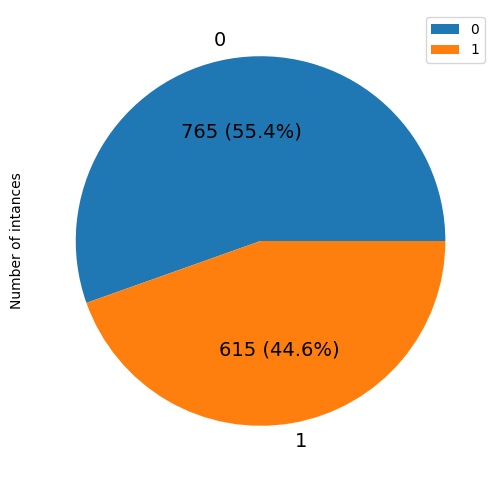

In [ ]:
get_dataset_statistics(augmented_dataset)

In [ ]:
aug_X_train = np.stack(np.array([get_text_vec(sms_text) for sms_text in augmented_dataset['text'].values]))

In [ ]:
aug_X_train.shape

(1380, 300)

In [ ]:
aug_y_train = augmented_dataset['label'].values

In [ ]:
aug_y_train.shape

(1380,)

In [ ]:
evaluation_metrics_aug = pd.DataFrame(columns = ['Recall', 'Precision', 'F1 score', 'F2 score'])

#Random Forest

train accuracy = 0.9442028985507246
test accuracy = 0.8961038961038961
Recall = 0.8205128205128205
Precision = 0.6530612244897959
F1 score = 0.7272727272727272
F2 score = 0.7804878048780486
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       192
           1       0.65      0.82      0.73        39

    accuracy                           0.90       231
   macro avg       0.81      0.87      0.83       231
weighted avg       0.91      0.90      0.90       231



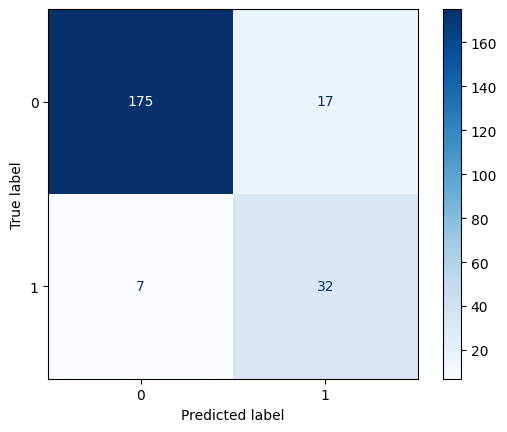

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 10, 'min_samples_split': 25, 'n_estimators': 150}


(0.7272727272727272, 0.7804878048780486)

In [ ]:
train(1, aug_X_train, aug_y_train, X_test, y_test, evaluation_metrics_aug, to_save=True, file_name='TDAS_RF')

#SVM

train accuracy = 0.9927536231884058
test accuracy = 0.974025974025974
Recall = 0.9743589743589743
Precision = 0.8837209302325582
F1 score = 0.9268292682926831
F2 score = 0.9547738693467336
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       192
           1       0.88      0.97      0.93        39

    accuracy                           0.97       231
   macro avg       0.94      0.97      0.96       231
weighted avg       0.98      0.97      0.97       231



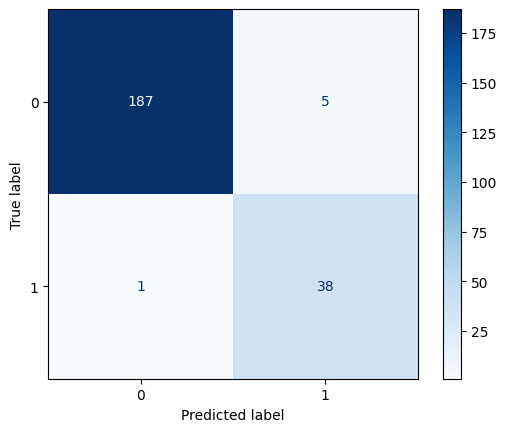

{'degree': 3, 'kernel': 'poly'}


(0.9268292682926831, 0.9547738693467336)

In [ ]:
train(2, aug_X_train, aug_y_train, X_test, y_test, evaluation_metrics_aug, to_save=True, file_name='TDAS_SVM')

In [ ]:
evaluation_metrics_aug

,Recall,Precision,F1 score,F2 score
RandomForest,0.820513,0.653061,0.727273,0.780488
SVM,0.974359,0.883721,0.926829,0.954774


#BiLSTM

In [ ]:
import random
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import L1L2
from sklearn.model_selection import StratifiedKFold

In [ ]:
text_words_lengths = [len(raw_data.loc[i]['text'].split()) for i in raw_data.index ]
total_length = np.sum(text_words_lengths)
text_words_mean = int(np.mean(text_words_lengths))

In [ ]:
def create_blstm_model(sent_length, words_mean, train_texts):

  text_vec = layers.TextVectorization( 
    max_tokens=sent_length,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=words_mean
  )

  text_vec.adapt(train_texts)

  embedding_layer = layers.Embedding(
    input_dim=sent_length,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=words_mean
  )

  input_layer = layers.Input(shape=(1,), dtype=tf.string) 

  vec_layer = text_vec(input_layer)
  embedding_layer_model = embedding_layer(vec_layer) 

  bi_lstm = layers.Bidirectional(layers.LSTM(64, activation='tanh', return_sequences=True, kernel_regularizer = L1L2(l1=0.01, l2=0.0)))(embedding_layer_model) 

  flatten = layers.Flatten()(bi_lstm) 
  dropout = layers.Dropout(.1)(flatten) 

  x = layers.Dense(32, activation='relu')(dropout) 

  output_layer = layers.Dense(1, activation='sigmoid')(x) 

  blstm_model = keras.Model(input_layer, output_layer) 

  blstm_model.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])  
  
  return blstm_model

# Cross Validation

In [ ]:
def cv_blstm(sent_length, words_mean):

  kf = StratifiedKFold(10, shuffle=True, random_state=42) 
  cv_metrics = pd.DataFrame(columns = ['Recall', 'Precision', 'F1 score', 'F2 score'])

  fold = 0

  X = augmented_dataset['text'].values
  Y = augmented_dataset['label'].values

  for train, val in kf.split(X, Y):  
  
    print(f"Fold {fold}")

    train_texts = X[train]
    train_labels = Y[train]
    test_texts = X[val]
    test_labels = Y[val]

    blstm_model = create_blstm_model(sent_length, words_mean, train_texts)

    history = blstm_model.fit(train_texts,
                              train_labels,
                              epochs=10,
                              batch_size=16,
                              validation_data=(test_texts, test_labels))

    blstm_model.evaluate(test_texts, test_labels)
    y_pred = np.round(blstm_model.predict(test_texts))

    f1_sc = f1_score(test_labels, y_pred)
    f2score = fbeta_score(test_labels, y_pred, beta=2, average='binary')

    cv_metrics.loc[fold, 'Recall'] = recall_score(test_labels, y_pred)
    cv_metrics.loc[fold, 'Precision'] = precision_score(test_labels, y_pred)
    cv_metrics.loc[fold, 'F1 score'] = f1_sc
    cv_metrics.loc[fold, 'F2 score'] = f2score
    
    fold += 1

  return cv_metrics

In [ ]:
cv_results = cv_blstm(total_length, text_words_mean)

Fold 0
Epoch 1/10
78/78 [==============================] - 18s 113ms/step - loss: 21.7036 - accuracy: 0.8551 - val_loss: 6.4032 - val_accuracy: 0.9710
Epoch 2/10
78/78 [==============================] - 3s 40ms/step - loss: 1.7179 - accuracy: 0.9839 - val_loss: 0.2308 - val_accuracy: 0.9855
Epoch 3/10
78/78 [==============================] - 2s 24ms/step - loss: 0.2082 - accuracy: 0.9944 - val_loss: 0.2506 - val_accuracy: 0.9783
Epoch 4/10
78/78 [==============================] - 1s 16ms/step - loss: 0.1310 - accuracy: 0.9992 - val_loss: 0.3831 - val_accuracy: 0.9493
Epoch 5/10
78/78 [==============================] - 1s 16ms/step - loss: 0.2362 - accuracy: 0.9976 - val_loss: 0.2012 - val_accuracy: 0.9855
Epoch 6/10
78/78 [==============================] - 1s 14ms/step - loss: 0.1178 - accuracy: 0.9992 - val_loss: 0.1580 - val_accuracy: 0.9855
Epoch 7/10
78/78 [==============================] - 1s 13ms/step - loss: 0.1304 - accuracy: 0.9960 - val_loss: 0.1787 - val_accuracy: 0.9855
Epo

In [ ]:
cv_results

,Recall,Precision,F1 score,F2 score
0,0.983871,0.968254,0.976,0.980707
1,1.0,0.984127,0.992,0.996785
2,1.0,1.0,1.0,1.0
3,1.0,0.96875,0.984127,0.99359
4,1.0,0.984127,0.992,0.996785
5,1.0,0.983871,0.99187,0.996732
6,0.983607,1.0,0.991736,0.986842
7,1.0,0.968254,0.983871,0.993485
8,1.0,0.983871,0.99187,0.996732
9,0.901639,1.0,0.948276,0.919732


In [ ]:
cv_results.mean()

Recall       0.986912
Precision    0.984125
F1 score     0.985175
F2 score     0.986139
dtype: float64

In [ ]:
aug_X_train = augmented_dataset['text'].values.reshape(-1, 1)

In [ ]:
aug_X_train.shape

(1380, 1)

In [ ]:
aug_y_train = augmented_dataset['label'].values.reshape(-1, 1)

In [ ]:
aug_y_train.shape

(1380, 1)

In [ ]:
X_test = test_data['text'].values.reshape(-1, 1)

In [ ]:
y_test = test_data['label'].values

In [ ]:
def train_blstm(sent_length, words_mean, train_texts, train_labels):

  blstm_model = create_blstm_model(sent_length, words_mean, train_texts)
  
  history = blstm_model.fit(train_texts,
                            train_labels,
                            epochs=10,
                            batch_size=16,
                            validation_data=(X_test, y_test))
  
  blstm_model.evaluate(X_test, y_test)
  y_pred = np.round(blstm_model.predict(X_test))

  f1_sc = f1_score(y_test, y_pred)
  f2score = fbeta_score(y_test, y_pred, beta=2, average='binary')


  print("test accuracy = " + str(accuracy_score(y_test, y_pred)))
  print("Recall = {}".format(recall_score(y_test, y_pred)))
  print("Precision = {}".format(precision_score(y_test, y_pred)))
  print("F1 score = {}".format(f1_sc))
  print("F2 score = {}".format(f2score))
  print(classification_report(y_test, y_pred))
  
  cm = confusion_matrix(y_test, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

  disp.plot(cmap=plt.cm.Blues)
  plt.show()

  return f1_sc

Epoch 1/10
87/87 [==============================] - 12s 88ms/step - loss: 20.0972 - accuracy: 0.8101 - val_loss: 4.4809 - val_accuracy: 0.9307
Epoch 2/10
87/87 [==============================] - 2s 25ms/step - loss: 1.0149 - accuracy: 0.9855 - val_loss: 0.3153 - val_accuracy: 0.9610
Epoch 3/10
87/87 [==============================] - 2s 25ms/step - loss: 0.1972 - accuracy: 0.9957 - val_loss: 0.2412 - val_accuracy: 0.9654
Epoch 4/10
87/87 [==============================] - 1s 14ms/step - loss: 0.1787 - accuracy: 0.9957 - val_loss: 0.2572 - val_accuracy: 0.9610
Epoch 5/10
87/87 [==============================] - 2s 18ms/step - loss: 0.1261 - accuracy: 0.9978 - val_loss: 0.2635 - val_accuracy: 0.9567
Epoch 6/10
87/87 [==============================] - 2s 24ms/step - loss: 0.1063 - accuracy: 0.9993 - val_loss: 0.1979 - val_accuracy: 0.9697
Epoch 7/10
87/87 [==============================] - 1s 11ms/step - loss: 0.2602 - accuracy: 0.9971 - val_loss: 0.2650 - val_accuracy: 0.9740
Epoch 8/10


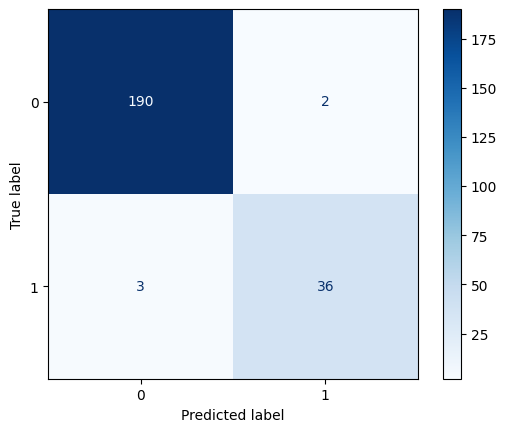

0.935064935064935

In [ ]:
train_blstm(total_length, text_words_mean, aug_X_train, aug_y_train)

Epoch 1/10
87/87 [==============================] - 12s 88ms/step - loss: 20.0522 - accuracy: 0.8188 - val_loss: 4.4732 - val_accuracy: 0.9610
Epoch 2/10
87/87 [==============================] - 2s 26ms/step - loss: 1.0127 - accuracy: 0.9899 - val_loss: 0.3709 - val_accuracy: 0.9654
Epoch 3/10
87/87 [==============================] - 1s 17ms/step - loss: 0.2256 - accuracy: 0.9913 - val_loss: 0.1778 - val_accuracy: 0.9827
Epoch 4/10
87/87 [==============================] - 1s 14ms/step - loss: 0.1988 - accuracy: 0.9935 - val_loss: 0.2103 - val_accuracy: 0.9827
Epoch 5/10
87/87 [==============================] - 1s 13ms/step - loss: 0.1228 - accuracy: 0.9978 - val_loss: 0.5727 - val_accuracy: 0.9524
Epoch 6/10
87/87 [==============================] - 1s 15ms/step - loss: 0.1609 - accuracy: 0.9986 - val_loss: 0.1716 - val_accuracy: 0.9827
Epoch 7/10
87/87 [==============================] - 1s 17ms/step - loss: 0.1100 - accuracy: 0.9978 - val_loss: 0.3901 - val_accuracy: 0.9827
Epoch 8/10


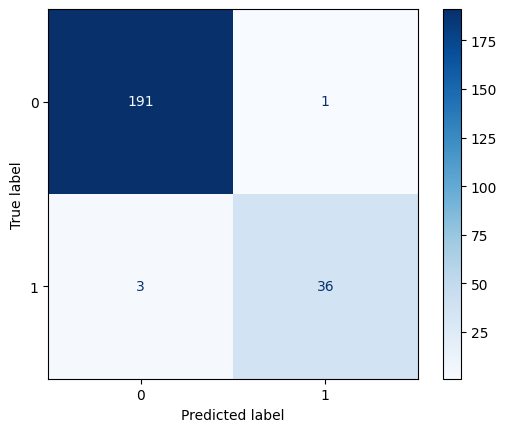

0.9473684210526315

In [ ]:
train_blstm(total_length, text_words_mean, aug_X_train, aug_y_train)